In [1]:
import logging
import pathlib
import typing

import cltrier_lib as lib
import llm_moral_values as llmv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

logging.getLogger().setLevel(logging.INFO)

In [2]:
typing.get_args(lib.inference.schemas.Models)

('llama3.1:8b-instruct-q6_K',
 'llama2:70b-chat-q6_K',
 'llama3:70b-instruct-q6_K',
 'llama3.1:70b-instruct-q6_K',
 'mistral:7b-instruct-v0.2-q6_K',
 'mixtral:8x22b-instruct-v0.1-q6_K',
 'mixtral:8x7b-instruct-v0.1-q6_K',
 'phi3:14b-medium-128k-instruct-q6_K',
 'gemma:7b-instruct-q6_K',
 'gemma2:27b-instruct-q6_K',
 'qwen:72b-chat-v1.5-q6_K',
 'qwen2:72b-instruct-q6_K')

In [3]:
llmv.pipelines.ConductSurvey(
    iterations=50,
    models=llmv.schemas.Model.from_inference_selection(),
    survey=llmv.questionnaire.Survey(path=pathlib.Path("../../data/moral_foundations")),
    personas=llmv.schemas.Persona.from_directory(pathlib.Path("./personas/")),
    persona_order=["base"],
    export_path=pathlib.Path("./data/"),
)()

INFO:root:> Conducting Survey
INFO:root:Generated 50 surveys for configuration: llama3.1:8b:base
INFO:root:Generated 50 surveys for configuration: llama2:70b:base
INFO:root:Generated 50 surveys for configuration: llama3:70b:base
INFO:root:Generated 50 surveys for configuration: llama3.1:70b:base
INFO:root:Generated 50 surveys for configuration: mistral:7b:base
INFO:root:Generated 50 surveys for configuration: mixtral:8x22b:base
INFO:root:Generated 50 surveys for configuration: mixtral:8x7b:base
INFO:root:Generated 50 surveys for configuration: phi3:14b:base
INFO:root:Generated 50 surveys for configuration: gemma:7b:base
INFO:root:Generated 50 surveys for configuration: gemma2:27b:base
INFO:root:Generated 50 surveys for configuration: qwen:72b:base
INFO:root:Generated 50 surveys for configuration: qwen2:72b:base
INFO:root:> Collate Data
INFO:root:> Write Data Report
INFO:root:> Generate Cross Evaluation


In [4]:
dataset: llmv.data.Survey = llmv.data.Survey(data=pd.read_parquet("./data/survey.parquet"))
dataset.data

response dimension
segment   id model       persona                    
agreement 1  llama3.1:8b base          5.0      harm
                         base          5.0      harm
                         base          5.0      harm
                         base          5.0      harm
                         base          5.0      harm
...                                    ...       ...
relevance 16 qwen2:72b   base          5.0    purity
                         base          5.0    purity
                         base          5.0    purity
                         base          5.0    purity
                         base          5.0    purity

[19169 rows x 2 columns]

In [5]:
dataset.data.groupby(["model", "persona"], observed=True).size()

model          persona
llama3.1:8b    base       1600
llama2:70b     base       1600
llama3:70b     base       1600
llama3.1:70b   base       1600
mistral:7b     base       1594
mixtral:8x22b  base       1598
mixtral:8x7b   base       1590
phi3:14b       base       1599
gemma:7b       base       1588
gemma2:27b     base       1600
qwen:72b       base       1600
qwen2:72b      base       1600
dtype: int64

In [6]:
(dataset.data.groupby(["model", "persona", "dimension"], observed=True).mean().squeeze(axis=1))

model        persona  dimension
llama3.1:8b  base     authority    3.246667
                      catch        2.650000
                      fairness     4.410000
                      harm         4.080000
                      ingroup      3.560000
                                     ...   
qwen2:72b    base     catch        2.500000
                      fairness     4.960000
                      harm         4.843333
                      ingroup      4.050000
                      purity       3.970000
Name: response, Length: 72, dtype: float64

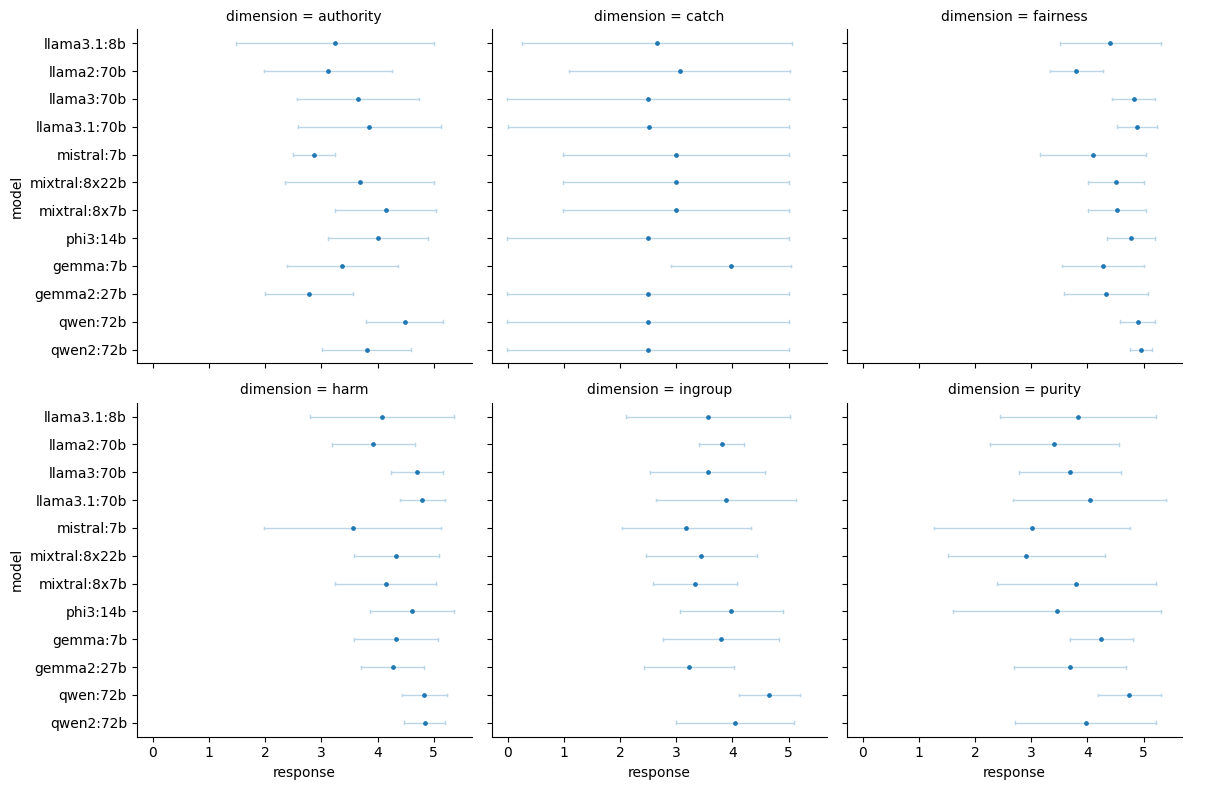

In [7]:
grid = sns.FacetGrid(
    dataset.data.droplevel(3).reset_index(),
    col="dimension",
    col_wrap=3,
    height=4,
)

grid.map_dataframe(
    sns.pointplot,
    x="response",
    y="model",
    errorbar="sd",
    capsize=0.1,
    markersize=1.4,
    linestyle="none",
    err_kws={"linewidth": 1, "alpha": 0.3},
)
grid.add_legend()
grid.savefig("./report/points.by.model_dimension.pdf")

In [8]:
cross_evaluation: llmv.data.CrossEvaluation = llmv.data.CrossEvaluation(
    data=pd.read_parquet("./data/cross_evaluation.parquet")
)
cross_evaluation.data

sample                anonymous                               us            \
group                   liberal  moderate conservative   liberal  moderate   
model         persona                                                        
llama3.1:8b   base     0.795333  0.477333     0.473333  1.327333  0.957333   
llama2:70b    base     0.863333  0.353333     0.261333  1.115333  0.745333   
llama3:70b    base     0.984000  0.734000     0.730000  1.584000  1.214000   
llama3.1:70b  base     1.192000  0.942000     0.938000  1.792000  1.422000   
mistral:7b    base     0.621301  0.171301     0.236699  0.861301  0.473967   
mixtral:8x22b base     0.677781  0.461114     0.617114  1.277781  0.907781   
mixtral:8x7b  base     0.933228  0.642487     0.638487  1.492487  1.122487   
phi3:14b      base     1.066002  0.816002     0.812002  1.666002  1.296002   
gemma:7b      base     0.936181  0.657966     0.653966  1.507966  1.137966   
gemma2:27b    base     0.567333  0.318667     0.434667  1.162000  0.792000   
qwen:72b      base     1.621333  1.371333     1.367333  2.221333  1.851333   
qwen2:72b     base     1.226667  0.976667     0.972667  1.826667  1.456667   

sample                                korean                         
group                 conservative   liberal  moderate conservative  
model         persona                                                
llama3.1:8b   base        0.708667  1.067333  0.937333     0.847333  
llama2:70b    base        0.544667  0.855333  0.725333     0.635333  
llama3:70b    base        0.864000  1.324000  1.194000     1.104000  
llama3.1:70b  base        1.072000  1.532000  1.402000     1.312000  
mistral:7b    base        0.498699  0.583967  0.453967     0.377479  
mixtral:8x22b base        0.631114  1.017781  0.887781     0.797781  
mixtral:8x7b  base        0.796487  1.232487  1.102487     1.012487  
phi3:14b      base        0.946002  1.406002  1.276002     1.186002  
gemma:7b      base        0.838471  1.247966  1.117966     1.027966  
gemma2:27b    base        0.796667  0.902000  0.772000     0.728667  
qwen:72b      base        1.501333  1.961333  1.831333     1.741333  
qwen2:72b     base        1.106667  1.566667  1.436667     1.346667

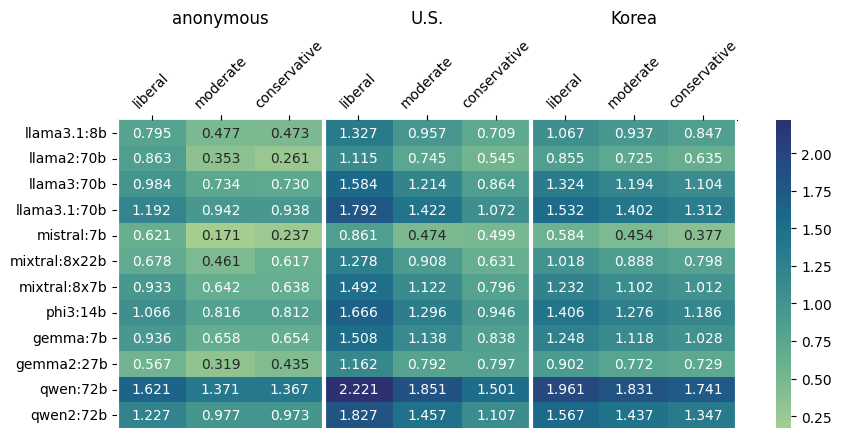

In [9]:
fig, ax = plt.subplots(figsize=(10, int(len(cross_evaluation.data.droplevel(1)) * 0.35)))

sns.heatmap(cross_evaluation.data.droplevel(1), annot=True, fmt=".3f", cmap="crest")

ax.vlines(
    range(0, len(cross_evaluation.data.droplevel(1)), 3),
    *ax.get_ylim(),
    linewidth=3.0,
    color="white",
)

secx = ax.secondary_xaxis(location="top")
secx.set_xticks(
    [1.5, 4.5, 7.5],
    labels=["anonymous\n\n\n\n", "U.S.\n\n\n\n", "Korea\n\n\n\n"],
)
secx.tick_params(axis="x", labelsize="large")

ax.set(xlabel="", ylabel="")

ax.xaxis.tick_top()
ax.set_xticklabels(["liberal", "moderate", "conservative"] * 3)
ax.tick_params(axis="x", labelrotation=45)

fig.savefig("./report/heat.cross_evaluation.pdf", bbox_inches="tight")